## **Packages and Device Setup**

In [1]:
# PyTorch and Data Handling
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader

# Core Python Packages
import numpy as np
import pandas as pd
import random
import os
import time
from collections import defaultdict

# Visualization
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Set device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: cuda


## **Directory Setting**

In [19]:
def change_directory(path):
    try:
        os.chdir(path)
        print(f"Directory changed to {os.getcwd()}")
    except FileNotFoundError:
        print("The specified directory does not exist.")
    except PermissionError:
        print("Permission denied.")
    except Exception as e:
        print(f"Error: {e}")

# Example usage
change_directory("/Users/murth/OneDrive/Desktop/hERG_toxicity")



Directory changed to c:\Users\murth\OneDrive\Desktop\hERG_toxicity


## **Convert .xlsx to .csv**

In [24]:
df = pd.read_excel('data/41598_2019_47536_MOESM2_ESM.xlsx', usecols=['Canonical_Smiles', 'class'])

df.to_csv('data/output_file.csv', index=False)


## **Load and Clean Dataset**

In [28]:
from rdkit import Chem

# Step 1: Load dataset
df = pd.read_csv("data/output_file.csv")  # Replace with your actual filename
print("Initial dataset shape:", df.shape)

# Step 2: Drop rows with missing SMILES or class
df = df.dropna(subset=["Canonical_Smiles", "class"])
print("After dropping NA rows:", df.shape)

# Step 3: Validate SMILES using RDKit
def is_valid_smiles(smi):
    return Chem.MolFromSmiles(smi) is not None

df["is_valid"] = df["Canonical_Smiles"].apply(is_valid_smiles)
df = df[df["is_valid"]].drop(columns=["is_valid"])
print("After removing invalid SMILES:", df.shape)

# Step 4: Check class balance
print("\nClass distribution:")
print(df["class"].value_counts())


Initial dataset shape: (203853, 2)
After dropping NA rows: (203853, 2)


[18:36:46] Explicit valence for atom # 15 N, 4, is greater than permitted
[18:36:46] Explicit valence for atom # 1 N, 4, is greater than permitted
[18:36:46] Explicit valence for atom # 1 N, 4, is greater than permitted
[18:36:46] Explicit valence for atom # 9 N, 4, is greater than permitted
[18:36:46] Explicit valence for atom # 1 N, 4, is greater than permitted
[18:36:46] Explicit valence for atom # 25 N, 4, is greater than permitted
[18:36:46] Explicit valence for atom # 1 N, 4, is greater than permitted
[18:36:46] Explicit valence for atom # 12 N, 4, is greater than permitted
[18:36:46] Explicit valence for atom # 16 N, 4, is greater than permitted
[18:36:46] Explicit valence for atom # 10 N, 4, is greater than permitted
[18:36:46] Explicit valence for atom # 13 N, 4, is greater than permitted
[18:36:46] Explicit valence for atom # 1 N, 4, is greater than permitted
[18:36:46] Explicit valence for atom # 11 N, 4, is greater than permitted
[18:36:46] Explicit valence for atom # 22 N,

After removing invalid SMILES: (190464, 2)

Class distribution:
class
0    184044
1      6420
Name: count, dtype: int64


## **Split the Dataset**

In [ ]:
from sklearn.model_selection import train_test_split

X = df["Canonical_Smiles"]
y = df["class"]

# Stratified split: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Combine back into DataFrames
train_df = pd.DataFrame({"Canonical_Smiles": X_train, "class": y_train}).reset_index(drop=True)
test_df = pd.DataFrame({"Canonical_Smiles": X_test, "class": y_test}).reset_index(drop=True)

# Show class balance
print("Training set class distribution:")
print(train_df["class"].value_counts())
print("\nTest set class distribution:")
print(test_df["class"].value_counts())


Training set class distribution:
class
0    147235
1      5136
Name: count, dtype: int64

Test set class distribution:
class
0    36809
1     1284
Name: count, dtype: int64


## **GNN SMILES-to-Graph**

In [ ]:
import torch
from torch_geometric.data import Data

# Atom feature extraction
def get_atom_features(atom):
    return torch.tensor([
        atom.GetAtomicNum(),                # Atomic number
        atom.GetDegree(),                   # Number of bonds
        atom.GetImplicitValence(),          # Implicit valence
        int(atom.GetIsAromatic()),          # Aromaticity
        atom.GetFormalCharge(),             # Formal charge
    ], dtype=torch.float)

# Bond type mapping
bond_type_to_int = {
    Chem.rdchem.BondType.SINGLE: 0,
    Chem.rdchem.BondType.DOUBLE: 1,
    Chem.rdchem.BondType.TRIPLE: 2,
    Chem.rdchem.BondType.AROMATIC: 3,
}

# Convert a single SMILES string to a PyTorch Geometric graph
def smiles_to_graph(smiles, label):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None

        # Atom features
        atom_features = [get_atom_features(atom) for atom in mol.GetAtoms()]
        if not atom_features:
            return None
        x = torch.stack(atom_features)

        # Edge index and edge attributes
        edge_index = []
        edge_attr = []

        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            bond_type = bond.GetBondType()
            bond_encoding = bond_type_to_int.get(bond_type, -1)
            if bond_encoding == -1:
                continue  # skip unknown bond types

            # Add edges in both directions
            edge_index.extend([[i, j], [j, i]])
            edge_attr.extend([[bond_encoding], [bond_encoding]])

        # Convert to tensors
        if not edge_index:
            return None  # skip molecules with no valid bonds

        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)

        y = torch.tensor([label], dtype=torch.long)

        return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

    except Exception as e:
        # Log or silently handle errors
        return None


**Process train_df in Parallel**

In [41]:
from joblib import Parallel, delayed
from tqdm import tqdm

def safe_smiles_to_graph(smi, label):
    try:
        return smiles_to_graph(smi, label)
    except:
        return None

train_graphs = Parallel(n_jobs=-1, backend='loky')(
    delayed(safe_smiles_to_graph)(smi, label)
    for smi, label in tqdm(zip(train_df['Canonical_Smiles'], train_df['class']), total=len(train_df))
)

train_graphs = [g for g in train_graphs if g is not None]


100%|██████████| 152371/152371 [03:00<00:00, 843.64it/s] 


**train_graph Save to File**

In [42]:
torch.save(train_graphs, "train_graphs.pt")

**Process test_df in Parallel**

In [ ]:
# Reuse the safe converter
def safe_smiles_to_graph(smi, label):
    try:
        return smiles_to_graph(smi, label)
    except:
        return None

# Convert test set to graphs using parallel processing
test_graphs = Parallel(n_jobs=-1, backend='loky')(
    delayed(safe_smiles_to_graph)(smi, label)
    for smi, label in tqdm(zip(test_df['Canonical_Smiles'], test_df['class']), total=len(test_df))
)

# Filter out failed conversions
test_graphs = [g for g in test_graphs if g is not None]


100%|██████████| 38093/38093 [01:26<00:00, 438.81it/s]


**test_graph Save to File**

In [52]:
# Save test graphs to file
torch.save(test_graphs, "test_graphs.pt")
print(f"Saved {len(test_graphs)} test graphs to test_graphs.pt")


Saved 38093 test graphs to test_graphs.pt


## **Load and Wrap the Graph Dataset**

**Step 1: Load the graphs**

In [ ]:
# Load previously saved graphs
train_graphs = torch.load("train_graphs.pt")

C:\Users\murth\AppData\Local\Temp\ipykernel_8884\4099995787.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_graphs = torch.load("train_graphs.pt")


**Step 2: Create PyG Dataset & DataLoader**

In [44]:
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader

# Optional: custom wrapper if you want PyG-style indexing
class GraphListDataset(Dataset):
    def __init__(self, graph_list):
        super().__init__()
        self.graphs = graph_list

    def len(self):
        return len(self.graphs)

    def get(self, idx):
        return self.graphs[idx]

# Wrap and create DataLoader
train_dataset = GraphListDataset(train_graphs)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


## **Split the graph data into train/val/test loaders**

**Step 1: Load Train Graphs**

In [ ]:
# Load your saved training graphs
train_graphs = torch.load("train_graphs.pt")

# Get the labels for stratified splitting
train_labels = [g.y.item() for g in train_graphs]

C:\Users\murth\AppData\Local\Temp\ipykernel_8884\2739835481.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_graphs = torch.load("train_graphs.pt")


**Step 2: Split into Train and Validation Sets**

In [46]:
# Stratified split: 80% train, 20% val
train_sub, val_sub = train_test_split(
    train_graphs,
    test_size=0.2,
    stratify=train_labels,
    random_state=42
)


**Step 3: Wrap into PyTorch Geometric Datasets**

In [47]:
from torch_geometric.data import Dataset

class GraphListDataset(Dataset):
    def __init__(self, graph_list):
        super().__init__()
        self.graphs = graph_list

    def len(self):
        return len(self.graphs)

    def get(self, idx):
        return self.graphs[idx]

train_dataset = GraphListDataset(train_sub)
val_dataset   = GraphListDataset(val_sub)


**Step 4: Create DataLoaders**

In [48]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)


**Process Test Graphs**

In [54]:
# Load and wrap as dataset and loader
test_graphs = torch.load("test_graphs.pt")
test_dataset = GraphListDataset(test_graphs)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

C:\Users\murth\AppData\Local\Temp\ipykernel_8884\3127310114.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_graphs = torch.load("test_graphs.pt")


## **GNNBinaryClassifier**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import NNConv, global_mean_pool, BatchNorm

class GNNBinaryClassifier(nn.Module):
    def __init__(self, node_input_dim=5, edge_input_dim=1, hidden_dim=64):
        super(GNNBinaryClassifier, self).__init__()

        # Edge MLP 1 → for NNConv layer 1
        self.edge_mlp1 = nn.Sequential(
            nn.Linear(edge_input_dim, hidden_dim * node_input_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim * node_input_dim, hidden_dim * node_input_dim)
        )

        self.conv1 = NNConv(
            in_channels=node_input_dim,
            out_channels=hidden_dim,
            nn=self.edge_mlp1,
            aggr='mean'
        )
        self.norm1 = BatchNorm(hidden_dim)

        # Edge MLP 2 → for NNConv layer 2
        self.edge_mlp2 = nn.Sequential(
            nn.Linear(edge_input_dim, hidden_dim * hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim * hidden_dim, hidden_dim * hidden_dim)
        )

        self.conv2 = NNConv(
            in_channels=hidden_dim,
            out_channels=hidden_dim,
            nn=self.edge_mlp2,
            aggr='mean'
        )
        self.norm2 = BatchNorm(hidden_dim)

        # Final MLP classifier head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = self.conv1(x, edge_index, edge_attr)
        x = self.norm1(x)
        x = F.relu(x)

        x = self.conv2(x, edge_index, edge_attr)
        x = self.norm2(x)
        x = F.relu(x)

        # Graph-level representation
        pooled = global_mean_pool(x, batch)

        # Output logits
        out = self.classifier(pooled)
        return out


**Step 1: Compute Class Weights for Loss**

In [ ]:
from collections import Counter

# Count class labels in train set
train_labels = [g.y.item() for g in train_sub]
label_counts = Counter(train_labels)
num_0 = label_counts[0]
num_1 = label_counts[1]
total = num_0 + num_1

# Calculate positive class weight
pos_weight = torch.tensor([total / (2.0 * num_1)], dtype=torch.float).to("cuda")


**Step 2: Define Model, Optimizer, and Loss**

In [57]:
model = GNNBinaryClassifier().to("cuda")

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)

# Binary Cross Entropy with Logits + imbalance-aware weighting
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)


**Step 3: Training & Evaluation Functions**

In [58]:
from sklearn.metrics import roc_auc_score

def train(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    for batch in loader:
        batch = batch.to("cuda")
        optimizer.zero_grad()
        out = model(batch).view(-1)
        loss = loss_fn(out, batch.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to("cuda")
            out = model(batch).view(-1)
            probs = torch.sigmoid(out)
            y_true.extend(batch.y.tolist())
            y_pred.extend(probs.tolist())
    auc = roc_auc_score(y_true, y_pred)
    return auc


**Add Learning Rate Scheduler**

In [60]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',         # because higher AUC is better
    factor=0.5,         # reduce LR by half
    patience=3,         # wait 3 epochs with no improvement
    verbose=True,
    min_lr=1e-6
)


c:\Users\murth\anaconda3\envs\pytorch\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


##  **Training Loop with Checkpointing & Logging**

In [ ]:
from tqdm import trange
from torch.optim.lr_scheduler import ReduceLROnPlateau

# File paths
CHECKPOINT_PATH = "gnn_checkpoint.pt"
HISTORY_LOG = "gnn_training_history.csv"
BEST_MODEL_PATH = "gnn_best_model.pt"

# Model, optimizer, scheduler
model = GNNBinaryClassifier().to("cuda")
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True, min_lr=1e-6)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Resume or initialize
history = []
start_epoch = 1
best_auc = 0
patience = 5
counter = 0

if os.path.exists(CHECKPOINT_PATH):
    print("🔁 Resuming from checkpoint...")
    checkpoint = torch.load(CHECKPOINT_PATH)
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    scheduler.load_state_dict(checkpoint['scheduler_state'])
    best_auc = checkpoint['best_auc']
    counter = checkpoint['counter']
    start_epoch = checkpoint['epoch'] + 1
    history = checkpoint['history']

# Training loop with tqdm
epochs = 20
progress_bar = trange(start_epoch, epochs + 1, desc="Training", leave=True)

for epoch in progress_bar:
    train_loss = train(model, train_loader, optimizer, loss_fn)
    val_auc = evaluate(model, val_loader)
    scheduler.step(val_auc)
    current_lr = optimizer.param_groups[0]['lr']

    # Update tqdm description
    progress_bar.set_description(
        f"Epoch {epoch:02d} | Loss: {train_loss:.4f} | Val AUC: {val_auc:.4f} | LR: {current_lr:.2e}"
    )

    # Save history
    history.append({
        "epoch": epoch,
        "train_loss": train_loss,
        "val_auc": val_auc,
        "lr": current_lr
    })

    # Save best model
    if val_auc > best_auc:
        best_auc = val_auc
        best_model_state = model.state_dict()
        counter = 0
        torch.save(best_model_state, BEST_MODEL_PATH)
    else:
        counter += 1
        if counter >= patience:
            print("⏹ Early stopping triggered.")
            break

    # Save checkpoint
    torch.save({
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'scheduler_state': scheduler.state_dict(),
        'best_auc': best_auc,
        'counter': counter,
        'history': history,
    }, CHECKPOINT_PATH)

# Final: Save log
pd.DataFrame(history).to_csv(HISTORY_LOG, index=False)


Epoch 20 | Loss: 0.5146 | Val AUC: 0.9123 | LR: 1.00e-03: 100%|██████████| 20/20 [1:10:31<00:00, 211.59s/it]


## **Evaluation**

**Step 1: Load Best Model + Test Set**

In [63]:
from sklearn.metrics import (
    roc_auc_score, confusion_matrix,
    precision_score, recall_score,
    f1_score, accuracy_score
)

# Load model
model.load_state_dict(torch.load("gnn_best_model.pt"))
model.eval()

# Load test data
test_graphs = torch.load("test_graphs.pt")
test_dataset = GraphListDataset(test_graphs)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


C:\Users\murth\AppData\Local\Temp\ipykernel_8884\2511190559.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("gnn_best_model.pt"))
C:\Use

**Step 2: Evaluate and Collect Predictions**

In [64]:
y_true = []
y_scores = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to("cuda")
        out = model(batch).view(-1)
        probs = torch.sigmoid(out)
        y_scores.extend(probs.cpu().tolist())
        y_true.extend(batch.y.cpu().tolist())


**Step 3: Convert to Class Labels (Threshold = 0.5)**

In [ ]:
y_pred = [1 if p >= 0.5 else 0 for p in y_scores]


**Step 4: Compute All Metrics**

In [66]:
auc = roc_auc_score(y_true, y_scores)
conf_mat = confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

print(f"ROC AUC      : {auc:.4f}")
print(f"Accuracy     : {accuracy:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"F1 Score     : {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_mat)


ROC AUC      : 0.9139
Accuracy     : 0.8978
Precision    : 0.2158
Recall       : 0.7718
F1 Score     : 0.3373

Confusion Matrix:
[[33208  3601]
 [  293   991]]


**Step 5: Plot ROC Curve**

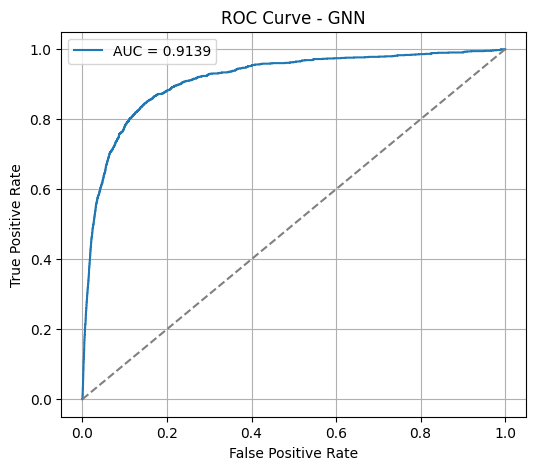

In [67]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_true, y_scores)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - GNN")
plt.legend()
plt.grid()
plt.show()
